# Data Pipelining

In [33]:
!pip install pandas numpy geopandas seaborn scikit-learn tensor folium folium matplotlib mapclassify earthengine-api geemap pyarrow xgboost

In [34]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
import pprint
import geemap
import ee
import folium

In [35]:
#Bringing in the original data frame

In [36]:
#Make sure the correct path to the classification_plots.zip is in the folder directory for the code to work efficient

In [37]:
# We are importing the observational data from the ZIP file provided (which contains the shape file) into a GeoDataFrame
gdf = gpd.read_file('../Costa_Rica_Data/Classification_Plots.zip')

# These display information about the GeoDataFrame to confirm the contains are what we expected
display(gdf.crs)
display(gdf.columns)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Index(['Source.Nam', 'plotid', 'sampleid', 'lon', 'lat', 'sample_geo', 'Uso',
       'Cobertura', 'Vegetacion', 'Herbaceas', 'Pasto_Arb', 'Cultivo',
       'Humedal', 'Terreno', 'Agua', 'Otra_clase', 'SAF', 'Cambios15_',
       'Gana_Perdi', 'geometry'],
      dtype='object')

In [38]:
k_clms = ['plotid','sampleid','Uso','Cobertura','Vegetacion','Herbaceas', 'Pasto_Arb', 'Cultivo','Humedal', 'Terreno','Agua','Otra_clase','SAF','Cambios15_','Gana_Perdi','geometry']
gdf1=gdf[k_clms]
#K columns is a list of column names we want to analyse  
#so we are creating a sub dataframe 

In [39]:
# Columns to replace NA values
sp_columns_to_replace = ['Uso', 'Cobertura', 'Vegetacion', 'Herbaceas', 'Pasto_Arb', 'Cultivo', 'Humedal', 'Terreno', 'Agua', 'Otra_clase', 'SAF', 'Cambios15_', 'Gana_Perdi']
en_columns_to_replace = ['Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss']

# Replace NA values with "Not_Applicable"
gdf1[sp_columns_to_replace] = gdf1[sp_columns_to_replace].fillna("No_Aplicable")

# Prints the NA count for column with NA values, just to double check
na_count = gdf1.isna().sum()
print(na_count)

plotid        0
sampleid      0
Uso           0
Cobertura     0
Vegetacion    0
Herbaceas     0
Pasto_Arb     0
Cultivo       0
Humedal       0
Terreno       0
Agua          0
Otra_clase    0
SAF           0
Cambios15_    0
Gana_Perdi    0
geometry      0
dtype: int64


/Users/jacquelinesanchez/Documents/Github/pytorch_class/.conda/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Now that we've cleaned the data from all NA values, and removed our duplicate quality control/quality assurance entires, let's save this dataset

In [40]:
#This code saves the dataframe 
#test = gpd.read_parquet('../Costa_Rica_Data/Setup Output/sp_setup_data.parquet')

In [41]:
# Saves the Spanish (original language) dataframe as a parquet file
#gdf1.to_parquet("./sp_clean_classification_data.parquet", engine="pyarrow")

In [42]:
# Create a makeshift subset of the original GeoDataFrame
downsampled_gdf = gdf1.iloc[::9]

# Calculate the mean geometric point to center the map
mean_point = downsampled_gdf.geometry.union_all().centroid
mean_lat, mean_lon = mean_point.y, mean_point.x

# Initialize a Folium map centered on the mean geometric point
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=9)

# Add each point from the downsampled GeoDataFrame to the map
for _, row in downsampled_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=1,  # Smaller radius for points
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7
    ).add_to(m)

# Display the map
display(m)

We extracted the medoid values for each point. The medoid values help describe the point numerically [gee extraction](John-CostaRica.ipynb)

In [43]:
# The output of John's Code (Spanish version)
gdf2 = gpd.read_parquet('../Costa_Rica_Data/Data Acquisition Output/extracted_gee_data/en_basic_gee_data.parquet')
gdf2.head()

plotid  sampleid         Use   CoverType        Vegetations  \
9     2902     11605    Wetlands  Vegetation              Trees   
12    2902     11608  Grasslands  Vegetation  Herbaceous plants   
13    2902     11609    Wetlands  Vegetation  Herbaceous plants   
15    2902     11611  Grasslands  Vegetation  Herbaceous plants   
16    2902     11612    Wetlands  Vegetation              Trees   

        Herbaceous          GrasslandShrub       CropsType     WetlandArea  \
9   Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   
12         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
13         Grasses          Not_Applicable  Not_Applicable   Swamp (Marsh)   
15         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
16  Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   

          LandType  ...    lai    mTPI      ndvi ocs_1mMed sand_1mMed  \
9   Not_Applicable  ...  0.305  8129.0  0.799771      68.0     332.15   
12  Not_Applicable  ...  0.305  8129.0  0.796553      68.0     332.15   
13  Not_Applicable  ...  0.260  8129.0  0.644415      65.0     340.45   
15  Not_Applicable  ...  0.305  8129.0  0.784331      68.0     332.15   
16  Not_Applicable  ...  0.260  8129.0  0.769357      65.0     340.45   

        savi  silt_1mMed     slope       topDiv   wetness  
9   0.393728      298.85  0.927410  1323.685053 -0.006312  
12  0.423713      298.85  2.935819  1323.685053 -0.014932  
13  0.380250      304.70  0.944368  1323.685053 -0.001697  
15  0.512687      298.85  0.927410  1323.685053 -0.027987  
16  0.360428      304.70  2.645556  1323.685053 -0.009912  

[5 rows x 44 columns]

# Data Cleaning

In [44]:
# Prints the NA count for column with NA values
na_count = gdf2.isna().sum()
print(na_count[na_count > 0])

BLUE            30
GREEN           26
NIR             26
RED             26
SWIR1           26
SWIR2           26
altura2       3527
brightness      26
diff            26
evi             30
hand30_100       3
mTPI           157
ndvi           339
savi            26
topDiv         157
wetness         26
dtype: int64


In [45]:
# Filling all the numeric values that are missing with the mean from the column
columns_to_fill = ['BLUE', 'GREEN', 'NIR', 'RED', 'SWIR1', 'SWIR2', 'altura2', 'brightness', 'diff', 'evi', 'hand30_100','mTPI', 'ndvi', 'savi', 'topDiv','wetness']  # Specify the columns to fill
for column in columns_to_fill:
    gdf2[column] = gdf2[column].fillna(gdf2[column].mean())
    gdf2[column] = gdf2[column].fillna(gdf2[column].mean())

In [46]:
# Prints the NA count for column with NA values
na_count = gdf2.isna().sum()
print(na_count[na_count > 0])

Series([], dtype: int64)


In [47]:
gdf2.head(5)

plotid  sampleid         Use   CoverType        Vegetations  \
9     2902     11605    Wetlands  Vegetation              Trees   
12    2902     11608  Grasslands  Vegetation  Herbaceous plants   
13    2902     11609    Wetlands  Vegetation  Herbaceous plants   
15    2902     11611  Grasslands  Vegetation  Herbaceous plants   
16    2902     11612    Wetlands  Vegetation              Trees   

        Herbaceous          GrasslandShrub       CropsType     WetlandArea  \
9   Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   
12         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
13         Grasses          Not_Applicable  Not_Applicable   Swamp (Marsh)   
15         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
16  Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   

          LandType  ...    lai    mTPI      ndvi ocs_1mMed sand_1mMed  \
9   Not_Applicable  ...  0.305  8129.0  0.799771      68.0     332.15   
12  Not_Applicable  ...  0.305  8129.0  0.796553      68.0     332.15   
13  Not_Applicable  ...  0.260  8129.0  0.644415      65.0     340.45   
15  Not_Applicable  ...  0.305  8129.0  0.784331      68.0     332.15   
16  Not_Applicable  ...  0.260  8129.0  0.769357      65.0     340.45   

        savi  silt_1mMed     slope       topDiv   wetness  
9   0.393728      298.85  0.927410  1323.685053 -0.006312  
12  0.423713      298.85  2.935819  1323.685053 -0.014932  
13  0.380250      304.70  0.944368  1323.685053 -0.001697  
15  0.512687      298.85  0.927410  1323.685053 -0.027987  
16  0.360428      304.70  2.645556  1323.685053 -0.009912  

[5 rows x 44 columns]

# Exploritory Data Analysis 

The exploritory data analysis is for the data scientist to investigate the data and have a better understanding of what the variables mean. This helps the feature selection process which is then fed to the modeling process. 
The normalized difference vegetation index (NDVI) is a simple graphical indication that may be used to analyse remote sensing data, often from a space platform, to determine whether or not the objective under observation has living green vegetation.

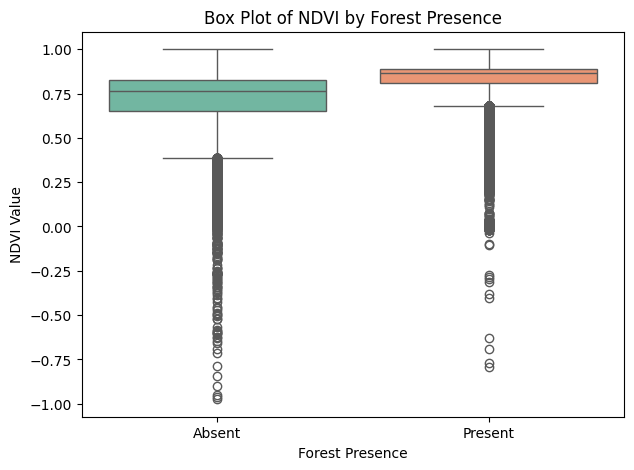

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a new column indicating 'Forest Present' or 'Absent'
gdf2['Forest_Presence'] = gdf2['Use'].apply(lambda x: 'Present' if x in ['Forest', 'Pasture ', 'Agriculture', 'Forest Plantation', 'WetLand'] else 'Absent')

# Create Boxplot with fixed palette assignment
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf2, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

In [49]:
#We are checking all the values that have a absents in forest
absent_use_values = gdf2[gdf2['Forest_Presence'] == 'Absent']['Use']
print(absent_use_values)

9           Wetlands
12        Grasslands
13          Wetlands
15        Grasslands
16          Wetlands
             ...    
101124    Grasslands
101125    Grasslands
101127    Grasslands
101128    Grasslands
101130    Grasslands
Name: Use, Length: 31412, dtype: object


In [50]:
#We are displaying the values in the absent section to learn what values it has 
unique_absent_use_values = absent_use_values.unique()
print(unique_absent_use_values)
use_counts = absent_use_values.value_counts()
print(use_counts)

['Wetlands' 'Grasslands' 'Other classes' 'Forest plantation'
 'No information' 'Not_Applicable']
Use
Grasslands           21793
Other classes         4732
Wetlands              3659
Forest plantation      838
No information         219
Not_Applicable         171
Name: count, dtype: int64


In [51]:
high_ndvi_absent = gdf2[(gdf2['Forest_Presence'] == 'Absent') & (gdf2['ndvi'] > 0.33)]

# Group by 'Vegetation' and calculate the mean NDVI
mean_ndvi_by_vegetation = high_ndvi_absent.groupby('Vegetations')['ndvi'].mean()
print(mean_ndvi_by_vegetation)

Vegetations
Herbaceous plants    0.738340
Not_Applicable       0.656511
Other vegetation     0.780386
Palms                0.853307
Shrubs               0.778165
Trees                0.796857
Name: ndvi, dtype: float64


As part of our exploratory data analysis, we are examining NDVI by setting thresholds to better understand its behavior. These thresholds allow us to observe why certain areas have high NDVI values, which typically indicate the presence of vegetation. However, we want to explore whether NDVI can be interpreted beyond just forest presence. Even in areas without dense forests, we still observe vegetation such as palms, shrubs, and smaller trees. By analyzing these variations, we aim to refine how NDVI is used in vegetation classification and assess whether it can be improved or complemented with other metrics.

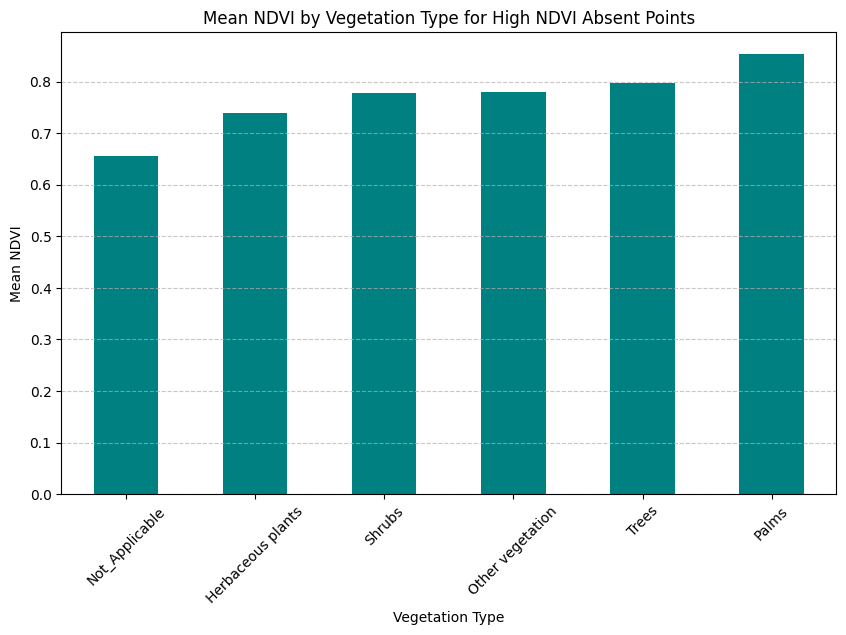

In [52]:


# Filter and group by 'Vegetation', calculating the mean NDVI
high_ndvi_absent = gdf2[(gdf2['Forest_Presence'] == 'Absent') & (gdf2['ndvi'] > 0.33)]
mean_ndvi_by_vegetation = high_ndvi_absent.groupby('Vegetations')['ndvi'].mean()

# Plot the results
plt.figure(figsize=(10, 6))
mean_ndvi_by_vegetation.sort_values().plot(kind='bar', color='teal')

# Customize the plot
plt.xlabel('Vegetation Type')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI by Vegetation Type for High NDVI Absent Points')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

We can say they NDVI is associated with greenery because a high NDVI indicates vegetation and the averge ndvi here is pretty high. Since a high ndvi represents vegetation or green on a map what if we take out all the ndvi scores below 33% and see how our data changes.

In [53]:
gdf2.loc[(gdf2['Forest_Presence'] == 'Absent') & (gdf2['ndvi'] > 0.33), 'Forest_Presence'] = 'Present'

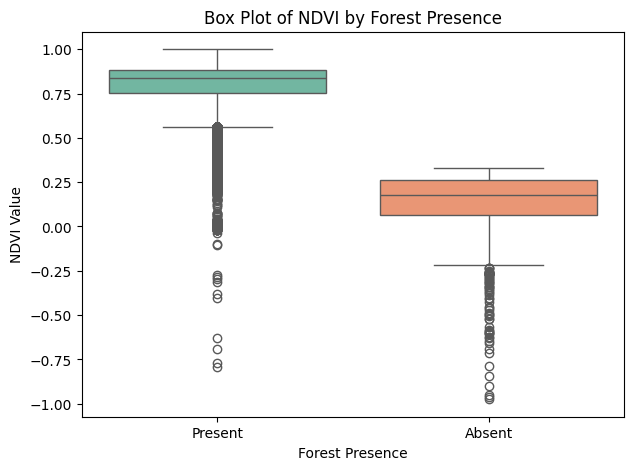

In [54]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf2, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()

So now I am sayng that there is a column in my df called forest_presents and if the ndvi is lower then 33% then that means there is forest absence.


In [55]:
q1 = gdf2[gdf2['Forest_Presence'] == 'Present']['ndvi'].quantile(0.25)
q3 = gdf2[gdf2['Forest_Presence'] == 'Present']['ndvi'].quantile(0.75)
iqr = q3 - q1
low_outlier_threshold = q1 - 1.5 * iqr

print(f"Low NDVI Outlier Threshold: {low_outlier_threshold}")
#To ensure the accuracy of our forest classification, we analyzed NDVI values for areas labeled as 'Present' in the Forest_Presence 
#column. Using the interquartile range (IQR) method, we identified a threshold for unusually low NDVI values that might indicate
#potential misclassifications or anomalies. Any NDVI value below this threshold is considered a low NDVI outlier, which could suggest mislabeled forest areas 
#or regions with sparse vegetation. This analysis helps refine our classification and improve the reliability of NDVI as an indicator of forest presence.

Low NDVI Outlier Threshold: 0.5611601201579609


In [56]:
low_ndvi_outliers = gdf2[(gdf2['Forest_Presence'] == 'Present') & (gdf2['ndvi'] < low_outlier_threshold)]
low_ndvi_outliers
#We are checking to see if the use values are some kind of green or forest when the NDVI is lower then usual. 

plotid  sampleid            Use      CoverType     Vegetations  \
18        2903     11609  Other classes  No vegetation  Not_Applicable   
19        2903     11610  Other classes  No vegetation  Not_Applicable   
63        2960     11837       Wetlands          Water  Not_Applicable   
66        2960     11840       Wetlands          Water  Not_Applicable   
67        2960     11841       Wetlands          Water  Not_Applicable   
...        ...       ...            ...            ...             ...   
101084  906847   3627390         Forest     Vegetation           Trees   
101085  906847   3627391         Forest     Vegetation           Trees   
101086  906847   3627392         Forest     Vegetation           Trees   
101087  906847   3627393         Forest     Vegetation           Trees   
101151  904894   3619573         Forest     Vegetation           Trees   

            Herbaceous  GrasslandShrub       CropsType     WetlandArea  \
18      Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
19      Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
63      Not_Applicable  Not_Applicable  Not_Applicable    Water bodies   
66      Not_Applicable  Not_Applicable  Not_Applicable    Water bodies   
67      Not_Applicable  Not_Applicable  Not_Applicable    Water bodies   
...                ...             ...             ...             ...   
101084  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101085  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101086  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101087  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   
101151  Not_Applicable  Not_Applicable  Not_Applicable  Not_Applicable   

              LandType  ...    mTPI      ndvi ocs_1mMed sand_1mMed      savi  \
18      Other surfaces  ...  8132.0  0.528579      63.0     336.45  0.295504   
19      Other surfaces  ...  8132.0  0.437536      63.0     336.45  0.152839   
63      Not_Applicable  ...  8127.0  0.503759      58.0     264.65  0.249684   
66      Not_Applicable  ...  8127.0  0.421427      58.0     264.65  0.172648   
67      Not_Applicable  ...  8127.0  0.451770      58.0     264.65  0.212015   
...                ...  ...     ...       ...       ...        ...       ...   
101084  Not_Applicable  ...  8157.0 -0.010946     132.0     321.90 -0.012102   
101085  Not_Applicable  ...  8232.0 -0.010758     132.0     323.55 -0.011875   
101086  Not_Applicable  ...  8232.0 -0.011036     132.0     321.90 -0.012187   
101087  Not_Applicable  ...  8157.0 -0.010568     132.0     321.90 -0.011680   
101151  Not_Applicable  ...  8137.0 -0.008563     126.0     296.95 -0.010184   

       silt_1mMed      slope       topDiv   wetness  Forest_Presence  
18         265.70   7.437723  1323.698838 -0.032052          Present  
19         265.70   2.645458  1323.698838 -0.016620          Present  
63         268.00   3.382467  1323.673565 -0.056526          Present  
66         268.00   0.000000  1323.673565 -0.026745          Present  
67         268.00   0.000000  1323.673565 -0.072998          Present  
...           ...        ...          ...       ...              ...  
101084     333.90  55.651031  1324.630000  0.455953          Present  
101085     324.50  37.565701  1324.630000  0.467968          Present  
101086     333.90  53.213791  1324.630000  0.462251          Present  
101087     333.90  49.832008  1324.630000  0.460804          Present  
101151     354.95  32.235409  1324.494757  0.537303          Present  

[5546 rows x 45 columns]

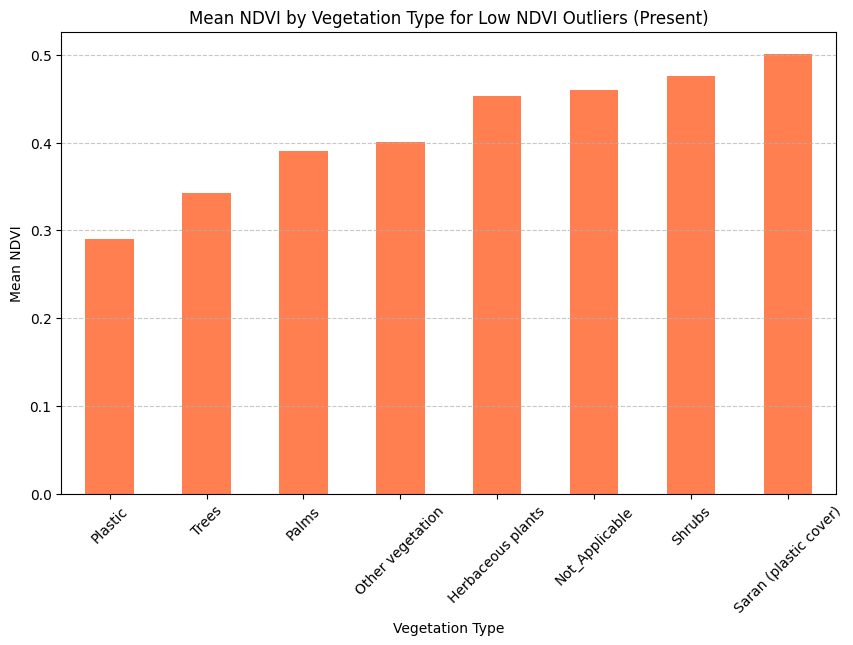

In [57]:
# Step 1: Calculate the IQR and identify low NDVI outliers for 'Present' Forest_Presence
q1 = gdf2[gdf2['Forest_Presence'] == 'Present']['ndvi'].quantile(0.25)
q3 = gdf2[gdf2['Forest_Presence'] == 'Present']['ndvi'].quantile(0.75)
iqr = q3 - q1
low_outlier_threshold = q1 - 1.5 * iqr

# Step 2: Filter the low NDVI outliers
low_ndvi_outliers = gdf2[(gdf2['Forest_Presence'] == 'Present') & (gdf2['ndvi'] < low_outlier_threshold)]

# Step 3: Group by 'Vegetation' and calculate the mean NDVI
mean_ndvi_outliers_by_vegetation = low_ndvi_outliers.groupby('Vegetations')['ndvi'].mean()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
mean_ndvi_outliers_by_vegetation.sort_values().plot(kind='bar', color='coral')

# Customize the plot
plt.xlabel('Vegetation Type')
plt.ylabel('Mean NDVI')
plt.title('Mean NDVI by Vegetation Type for Low NDVI Outliers (Present)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


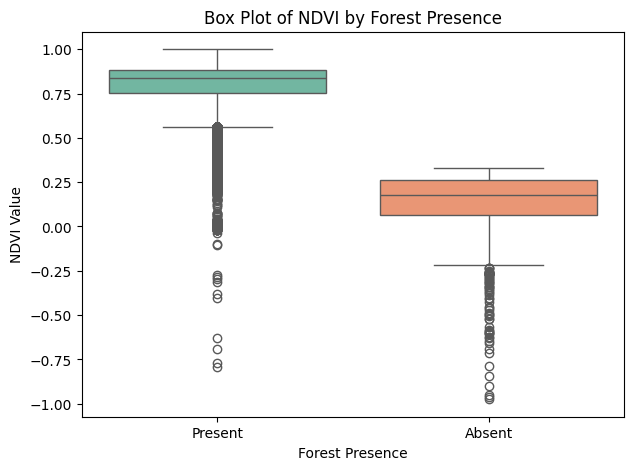

    plotid  sampleid         Use   CoverType        Vegetations  \
9     2902     11605    Wetlands  Vegetation              Trees   
12    2902     11608  Grasslands  Vegetation  Herbaceous plants   
13    2902     11609    Wetlands  Vegetation  Herbaceous plants   
15    2902     11611  Grasslands  Vegetation  Herbaceous plants   
16    2902     11612    Wetlands  Vegetation              Trees   

        Herbaceous          GrasslandShrub       CropsType     WetlandArea  \
9   Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   
12         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
13         Grasses          Not_Applicable  Not_Applicable   Swamp (Marsh)   
15         Grasses  Mixed Pasture (70-90%)  Not_Applicable  Not_Applicable   
16  Not_Applicable          Not_Applicable  Not_Applicable   Swamp (Marsh)   

          LandType  ...    mTPI      ndvi ocs_1mMed sand_1mMed      savi  \
9   Not_Applicable  ...  8129.0  0.799771      68.0 

In [58]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='Forest_Presence', y='ndvi', data=gdf2, hue='Forest_Presence', palette="Set2", legend=False)

# Labels and title
plt.xlabel("Forest Presence")
plt.ylabel("NDVI Value")
plt.title("Box Plot of NDVI by Forest Presence")

# Show plot
plt.show()
print(gdf2.head())

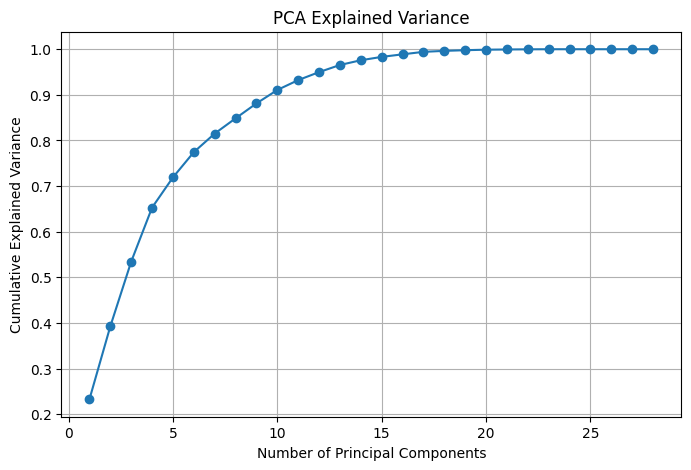

In [59]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
features = gdf2.drop(['Forest_Presence', 'plotid', 'sampleid', 'Use', 'CoverType', 'Vegetations', 'Herbaceous', 'GrasslandShrub', 'CropsType', 'WetlandArea', 'LandType', 'WaterBodyType', 'OtherClass', 'SAF', 'Changes_15', 'Gain_Loss', 'geometry'], axis=1)  # Adjust columns as needed
features_scaled = StandardScaler().fit_transform(features)

# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(features_scaled)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

In [60]:
# Retain the first 9 or 10 components
n_components = 12  # or 9, depending on how much variance you want to retain
reduced_data = principal_components[:, :n_components]

# Convert it back to a DataFrame for easier handling
reduced_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components)])

# Add your target variable (Forest_Presence) back to the reduced dataset if needed
reduced_df['Forest_Presence'] = gdf2['Forest_Presence'].values

# Show the first few rows of the reduced data
print(reduced_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.293332 -1.837715 -1.221866  0.262553  0.759845  1.780217  0.715952   
1 -0.298827 -3.020864  0.753586  1.986402  0.310587  1.303170  0.680551   
2  1.477013 -0.566561 -1.675973 -0.814450  0.721028  1.742934  0.629332   
3  1.606029  1.631651 -3.048346 -0.420528 -0.138250  0.868924  0.487024   
4 -0.496026 -3.593084  0.269709  1.192702  0.636611  1.702571  0.749179   

        PC8       PC9      PC10      PC11      PC12 Forest_Presence  
0  0.050124  0.164082  0.032083  0.256864 -0.406719         Present  
1 -0.121381  0.226985 -0.038734  0.202894 -0.409633         Present  
2 -0.085434  0.293895  0.075413  0.374638 -0.168606         Present  
3 -0.207749  0.185173 -0.091955  0.131265 -0.398700         Present  
4 -0.086336  0.361164 -0.057432  0.416056 -0.186218         Present  


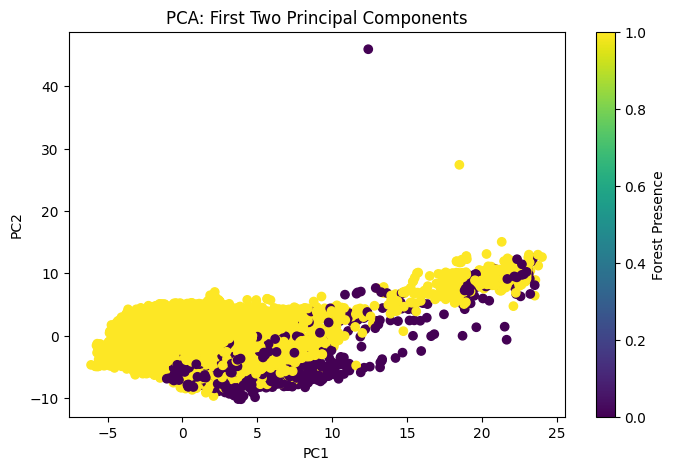

In [61]:
# Visualize the first two principal components
plt.figure(figsize=(8, 5))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=reduced_df['Forest_Presence'].map({'Present': 1, 'Absent': 0}), cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First Two Principal Components')
plt.colorbar(label='Forest Presence')
plt.show()

In [62]:
#import packages
import geopandas as gpd, pandas as pd, os, numpy as np
import ee, geemap
from geemap import ml

### Authenticate into Earth Engine

In [63]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-jacquelinesancheza14') #you will want to select your personal cloud project


Successfully saved authorization token.


## Create definitions for the median and medoid procedures

In [64]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    #Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, overwrite=True).addBands(thermalBands, overwrite=True).updateMask(qaMask).updateMask(saturationMask)

def median_mosaic(image,fltr=None,refl_bands=['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']):
    if(fltr is None):
        inCollection = image.filter(fltr).select(refl_bands)
    else:
        inCollection = image.filter(fltr).select(refl_bands)

    return inCollection.median()

def _medoid(col):
    median = ee.ImageCollection(col).median()
    diff=ee.Image(col).subtract(median).pow(ee.Image.constant(2))
    return diff.reduce('sum').addBands(col)


def medoid_mosaic(image, fltr,refl_bands=['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']):
    if(fltr is None):
        inCollection = image.filter(fltr).select(refl_bands)
    else:
        inCollection = image.filter(fltr).select(refl_bands)

    medoid = inCollection.map(_medoid)
    medoid = ee.ImageCollection(medoid).reduce(ee.Reducer.min(7)).select([1,2,3,4,5,6], refl_bands)
    return medoid



## Set various variable and create the medoid surface on ee

In [65]:
#make lists fo band names for selections
lc8_bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'QA_PIXEL']#landsat band names
tgt_bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'TEMP', 'QA_PIXEL']#common band names
refl_bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2']#bands we care about

#specify start and end dates for the image filter
startDate = '2021-01-01'
endDate = '2024-07-01'

#Specify julian dates for filter. Here we want to select sunny months
julianStart1 = 350# Starting Julian Date (for landsat median cloud free )
julianEnd1 = 365
julianStart2 = 1
julianEnd2 = 150# Ending Julian date (for landsat median cloud free)

#define the study area extent from our convex hull
#geo=geemap.gdf_to_ee(gpd.GeoDataFrame(geometry=chul)) #convert our convex hull into a ee feature class object

#make the ee collection
l8_col=ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

#set various filters
#f_bnds=ee.Filter.bounds(geometry=geo)
f_date=ee.Filter.date(startDate,endDate)
f_cr1=ee.Filter.calendarRange(julianStart1,julianEnd1)
f_cr2=ee.Filter.calendarRange(julianStart2,julianEnd2)
f_or=ee.Filter.Or(f_cr1,f_cr2)
f_and=ee.Filter.And(f_date,f_or)

#use our filter on the landsat collection
l8=l8_col.filter(f_and).map(maskL8sr)
l8r=l8.select(lc8_bands,tgt_bands)

#call the medoid function
medoid = medoid_mosaic(l8r,fltr=f_and,refl_bands=refl_bands)

#get the elevation data
dem = ee.Image("USGS/SRTMGL1_003")

#Create Raster Predictors
pred_rs=ee.Image([medoid,dem])

## Make Random Forest Model
#### Make the sklearn model and convert it into a google earth engine model
We will be using our cleaned data. If you have not already worked through the [Summarizing plot data](./Summarizing_plot_data.ipynb) notebook, please do so before continuing. Our response and predictor variables are as follows:-
- response = Use2
- predictors = ['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2','elevation']

In [ ]:
from sklearn.ensemble import RandomForestClassifier

df = gdf2.copy()
#pd.read_csv('./plot_subplot_data.csv')
resp='Use2'
pred=['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2','elevation']

#mapping to integers
uvls=df['Use'].unique()
cdic=dict(zip(uvls,np.arange(uvls.shape[0])))
df['Use2']=df['Use'].map(cdic)

#subset the data to send the model to Google EE
ss=int(df.shape[0]*0.1)
sdf=df.sample(ss)
X=sdf[pred]
y=sdf[resp]

rf=RandomForestClassifier(n_estimators=10,max_samples=0.75,random_state=0,oob_score=True) # reduce the number of models for ee
rf.fit(X,y)
print('Label Dictionary:')
display(cdic)
print('OOB = ',rf.oob_score_)

Label Dictionary:


/Users/jacquelinesanchez/Documents/Github/pytorch_class/.conda/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


{'Wetlands': np.int64(0),
 'Grasslands': np.int64(1),
 'Other classes': np.int64(2),
 'Forest': np.int64(3),
 'Agriculture': np.int64(4),
 'Forest plantation': np.int64(5),
 'No information': np.int64(6),
 'Not_Applicable': np.int64(7)}

OOB =  0.6499836796866499


### Convert the sklearn model to strings to upload into a classifier using Geemap's ml module

In [67]:
rf_str=ml.rf_to_strings(rf,pred)

### Convert the strings into a ee classifier using Geemap's ml module

In [68]:
clsf=ml.strings_to_classifier(rf_str)

### Create the ee classified imgage using Earth Engine functions

In [69]:
classified = pred_rs.select(pred).classify(clsf)

## Visualize the Medoid image and classification

In [70]:
Map = geemap.Map()

Map.set_center(lon=-83.7534,lat=9.7489,zoom=8)

Map.addLayer(
    pred_rs,
    {"bands": ["RED", "GREEN", "BLUE"], "min": 0, "max": 0.25, "gamma": 1.5},
    "Medoid",
)
Map.addLayer(
    classified,
    {"min": 0, "max": 7, "palette": ["green", "tan", "blue","white","yellow","lightgreen","grey","grey"]},
    "classification",
)

Map

Map(center=[9.7489, -83.7534], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [ ]:
# Step 1: Map labels to integers and save both directions
uvls = df['Use'].unique()
cdic = dict(zip(uvls, np.arange(len(uvls))))
reverse_cdic = {v: k for k, v in cdic.items()}

df['Use2'] = df['Use'].map(cdic)

# Step 2: Define your predictors and train RF
X = df[pred]
y = df['Use2']

rf = RandomForestClassifier(n_estimators=10, max_samples=0.75, random_state=0, oob_score=True)
rf.fit(X, y)

# Step 3: Prepare palette for visualization
label_palette = {
    'Wetlands': 'blue',
    'Grasslands': 'green',
    'Other classes': 'white',
    'Forest': 'darkgreen',
    'Agriculture': 'yellow',
    'Forest plantation': 'lightgreen',
    'No information': 'grey',
    'Not_Applicable': 'grey'
}
palette = [label_palette[label] for label in uvls]  # Ensure it's in the same order as mapped

# Step 4: Classify and map in Earth Engine
rf_str = ml.rf_to_strings(rf, pred)
clsf = ml.strings_to_classifier(rf_str)

classified = pred_rs.select(pred).classify(clsf)

Map = geemap.Map()
Map.set_center(lon=-83.7534, lat=9.7489, zoom=8)

Map.addLayer(pred_rs, {"bands": ["RED", "GREEN", "BLUE"], "min": 0, "max": 0.25, "gamma": 1.5}, "Medoid")
Map.addLayer(classified, {"min": 0, "max": len(uvls)-1, "palette": palette}, "classification")
Map
